In [3]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

<Client: 'tcp://127.0.0.1:41325' processes=2 threads=4, memory=1.86 GiB>

In [4]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries()

In [5]:
df

Dask DataFrame Structure:
                   id    name        x        y
npartitions=30                                 
2000-01-01      int64  object  float64  float64
2000-01-02        ...     ...      ...      ...
...               ...     ...      ...      ...
2000-01-30        ...     ...      ...      ...
2000-01-31        ...     ...      ...      ...
Dask Name: make-timeseries, 30 tasks

In [6]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

In [7]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [8]:
df.head(3)

id   name     x     y
timestamp                                   
2000-01-01 00:00:00   964    Bob -0.35 -0.15
2000-01-01 00:00:01   957    Bob -0.03  0.30
2000-01-01 00:00:02  1002  Zelda -0.43 -0.24

In [15]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

In [16]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [17]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

In [18]:
df = df.persist()

In [19]:
%matplotlib inline

In [20]:
df[['x', 'y']].resample('1h').mean().head()

x         y
timestamp                              
2000-01-01 00:00:00 -1.46e-02  5.41e-03
2000-01-01 01:00:00  2.04e-02 -7.45e-03
2000-01-01 02:00:00  1.09e-02 -1.37e-04
2000-01-01 03:00:00 -1.32e-02  1.43e-02
2000-01-01 04:00:00 -8.85e-04 -7.00e-03

<AxesSubplot:xlabel='timestamp'>

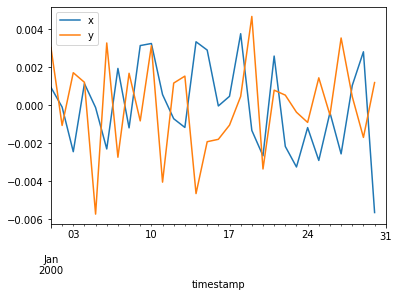

In [22]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [23]:
df[['x', 'y']].rolling(window='24h').mean().head()

/home/jovyan/conda-envs/river/lib/python3.8/site-packages/dask/dataframe/rolling.py:276: FutureWarning: win_type will no longer return 'freq' in a future version. Check the type of self.window instead.
  self._win_type = pd_roll.win_type


x     y
timestamp                      
2000-01-01 00:00:00 -0.35 -0.15
2000-01-01 00:00:01 -0.19  0.08
2000-01-01 00:00:02 -0.27 -0.03
2000-01-01 00:00:03 -0.32  0.15
2000-01-01 00:00:04 -0.43  0.07

In [24]:
df

Dask DataFrame Structure:
                   id    name        x        y
npartitions=30                                 
2000-01-01      int64  object  float64  float64
2000-01-02        ...     ...      ...      ...
...               ...     ...      ...      ...
2000-01-30        ...     ...      ...      ...
2000-01-31        ...     ...      ...      ...
Dask Name: make-timeseries, 30 tasks

In [25]:
df = df.set_index('name')
df

Dask DataFrame Structure:
                   id        x        y
npartitions=30                         
Alice           int64  float64  float64
Alice             ...      ...      ...
...               ...      ...      ...
Zelda             ...      ...      ...
Zelda             ...      ...      ...
Dask Name: sort_index, 1140 tasks

In [26]:
df = df.persist()

In [27]:
%time df.loc['Alice'].compute()

CPU times: user 20.8 ms, sys: 7.23 ms, total: 28 ms
Wall time: 64.5 ms


id     x     y
name                   
Alice  1025 -0.64  0.63
Alice   951 -0.86  0.12
Alice   978 -0.41 -0.64
Alice  1003  0.04  0.35
Alice   944  0.46 -0.33
...     ...   ...   ...
Alice   985 -0.07 -0.47
Alice  1046 -0.51  0.74
Alice   934 -0.24  0.29
Alice  1001  0.12 -1.00
Alice  1003  0.40  0.13

[99726 rows x 3 columns]

In [28]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

In [29]:
df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression()
Bob        LinearRegression()
Charlie    LinearRegression()
Dan        LinearRegression()
Edith      LinearRegression()
                  ...        
Victor     LinearRegression()
Wendy      LinearRegression()
Xavier     LinearRegression()
Yvonne     LinearRegression()
Zelda      LinearRegression()
Length: 26, dtype: object